In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
df_train  = pd.read_csv("data/train.csv")
df_sample = pd.read_csv("data/sample_submission.csv")
df_test   = pd.read_csv("data/train.csv")

labels = ['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight',
 'Obesity_Type_III' ,'Obesity_Type_II' ,'Overweight_Level_I',
 'Obesity_Type_I']

# drop id (not useful)
df_train.drop('id',axis=1,inplace=True)
df_test.drop('id',axis=1,inplace=True)

In [4]:
# add BMI
df_train['BMI'] = (df_train['Weight'] / df_train['Height']**2)
# display(df_train)

In [5]:
print(df_train.shape)

(20758, 18)


In [6]:
# number of na
mv = df_train.isna().sum().sum()

# number of duplicates
dv = df_train.duplicated().sum()

# there are no NAs or Duplicates in the test dataset
print(mv)
print(dv)

0
0


In [7]:
display(df_train.describe(include=[np.number]).T, df_train.describe(include=[object]).T)

,count,mean,std,min,25%,50%,75%,max
Age,20758.0,23.841804,5.688072,14.000000,20.000000,22.815416,26.000000,61.000000
Height,20758.0,1.700245,0.087312,1.450000,1.631856,1.700000,1.762887,1.975663
Weight,20758.0,87.887768,26.379443,39.000000,66.000000,84.064875,111.600553,165.057269
FCVC,20758.0,2.445908,0.533218,1.000000,2.000000,2.393837,3.000000,3.000000
NCP,20758.0,2.761332,0.705375,1.000000,3.000000,3.000000,3.000000,4.000000
CH2O,20758.0,2.029418,0.608467,1.000000,1.792022,2.000000,2.549617,3.000000
FAF,20758.0,0.981747,0.838302,0.000000,0.008013,1.000000,1.587406,3.000000
TUE,20758.0,0.616756,0.602113,0.000000,0.000000,0.573887,1.000000,2.000000
BMI,20758.0,30.241842,8.333932,12.868541,24.088223,29.384757,37.011168,54.997991


,count,unique,top,freq
Gender,20758,2,Female,10422
family_history_with_overweight,20758,2,yes,17014
FAVC,20758,2,yes,18982
CAEC,20758,4,Sometimes,17529
SMOKE,20758,2,no,20513
SCC,20758,2,no,20071
CALC,20758,3,Sometimes,15066
MTRANS,20758,5,Public_Transportation,16687
NObeyesdad,20758,7,Obesity_Type_III,4046


In [8]:
numerical_cols   = df_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = df_train.select_dtypes(include=[object]).columns.tolist()

num_numerical_cols = len(numerical_cols)
num_numerical_rows = num_numerical_cols // 4

num_categorical_cols = len(categorical_cols)
num_categorical_rows = num_categorical_cols // 4

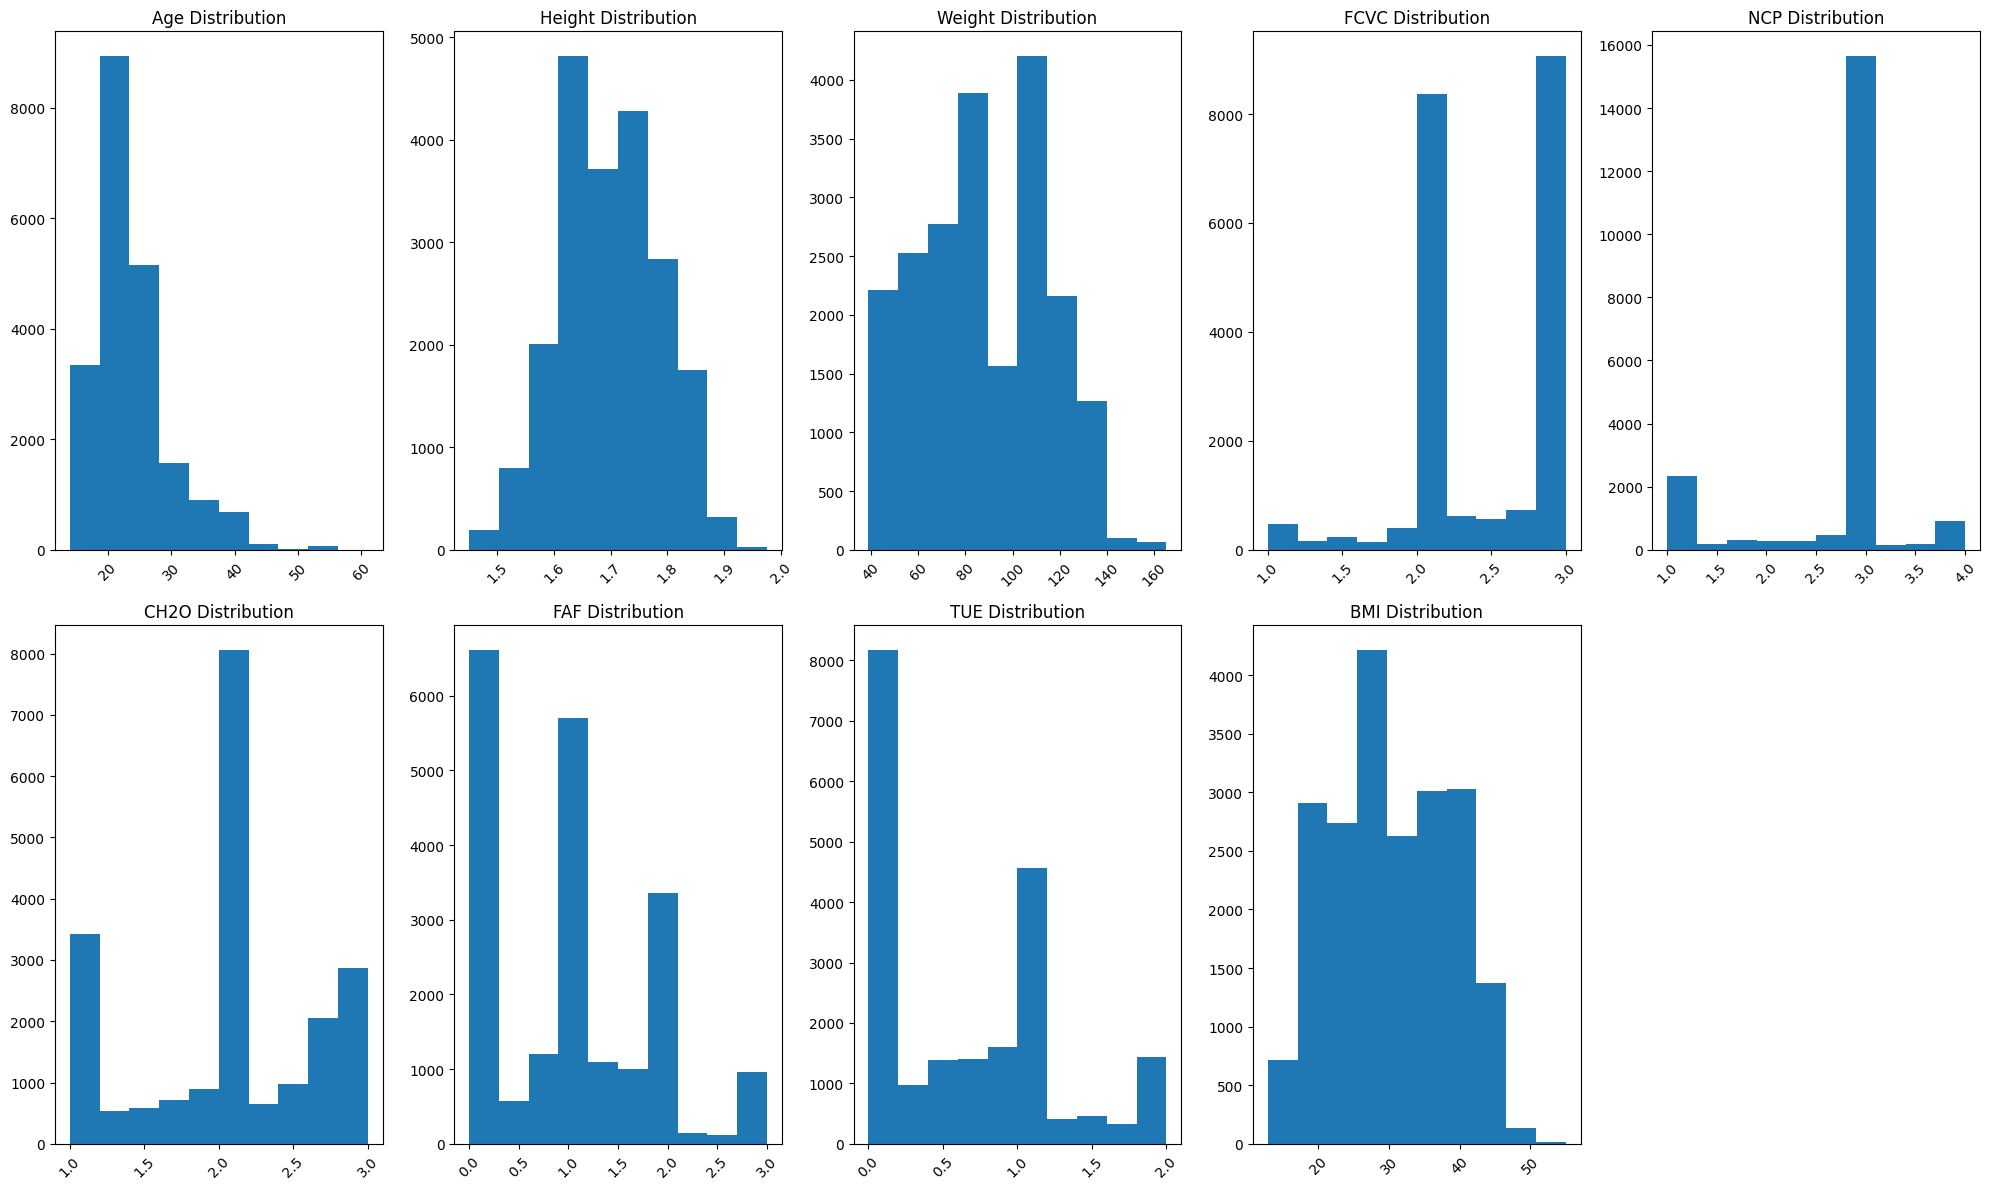

In [9]:
# numerical cols histogram
plt.figure(figsize=(20,6 * num_numerical_rows))
for i ,col in enumerate(numerical_cols,1):
    plt.subplot(num_numerical_rows, 5, i)
    plt.hist(df_train[col])
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show() 


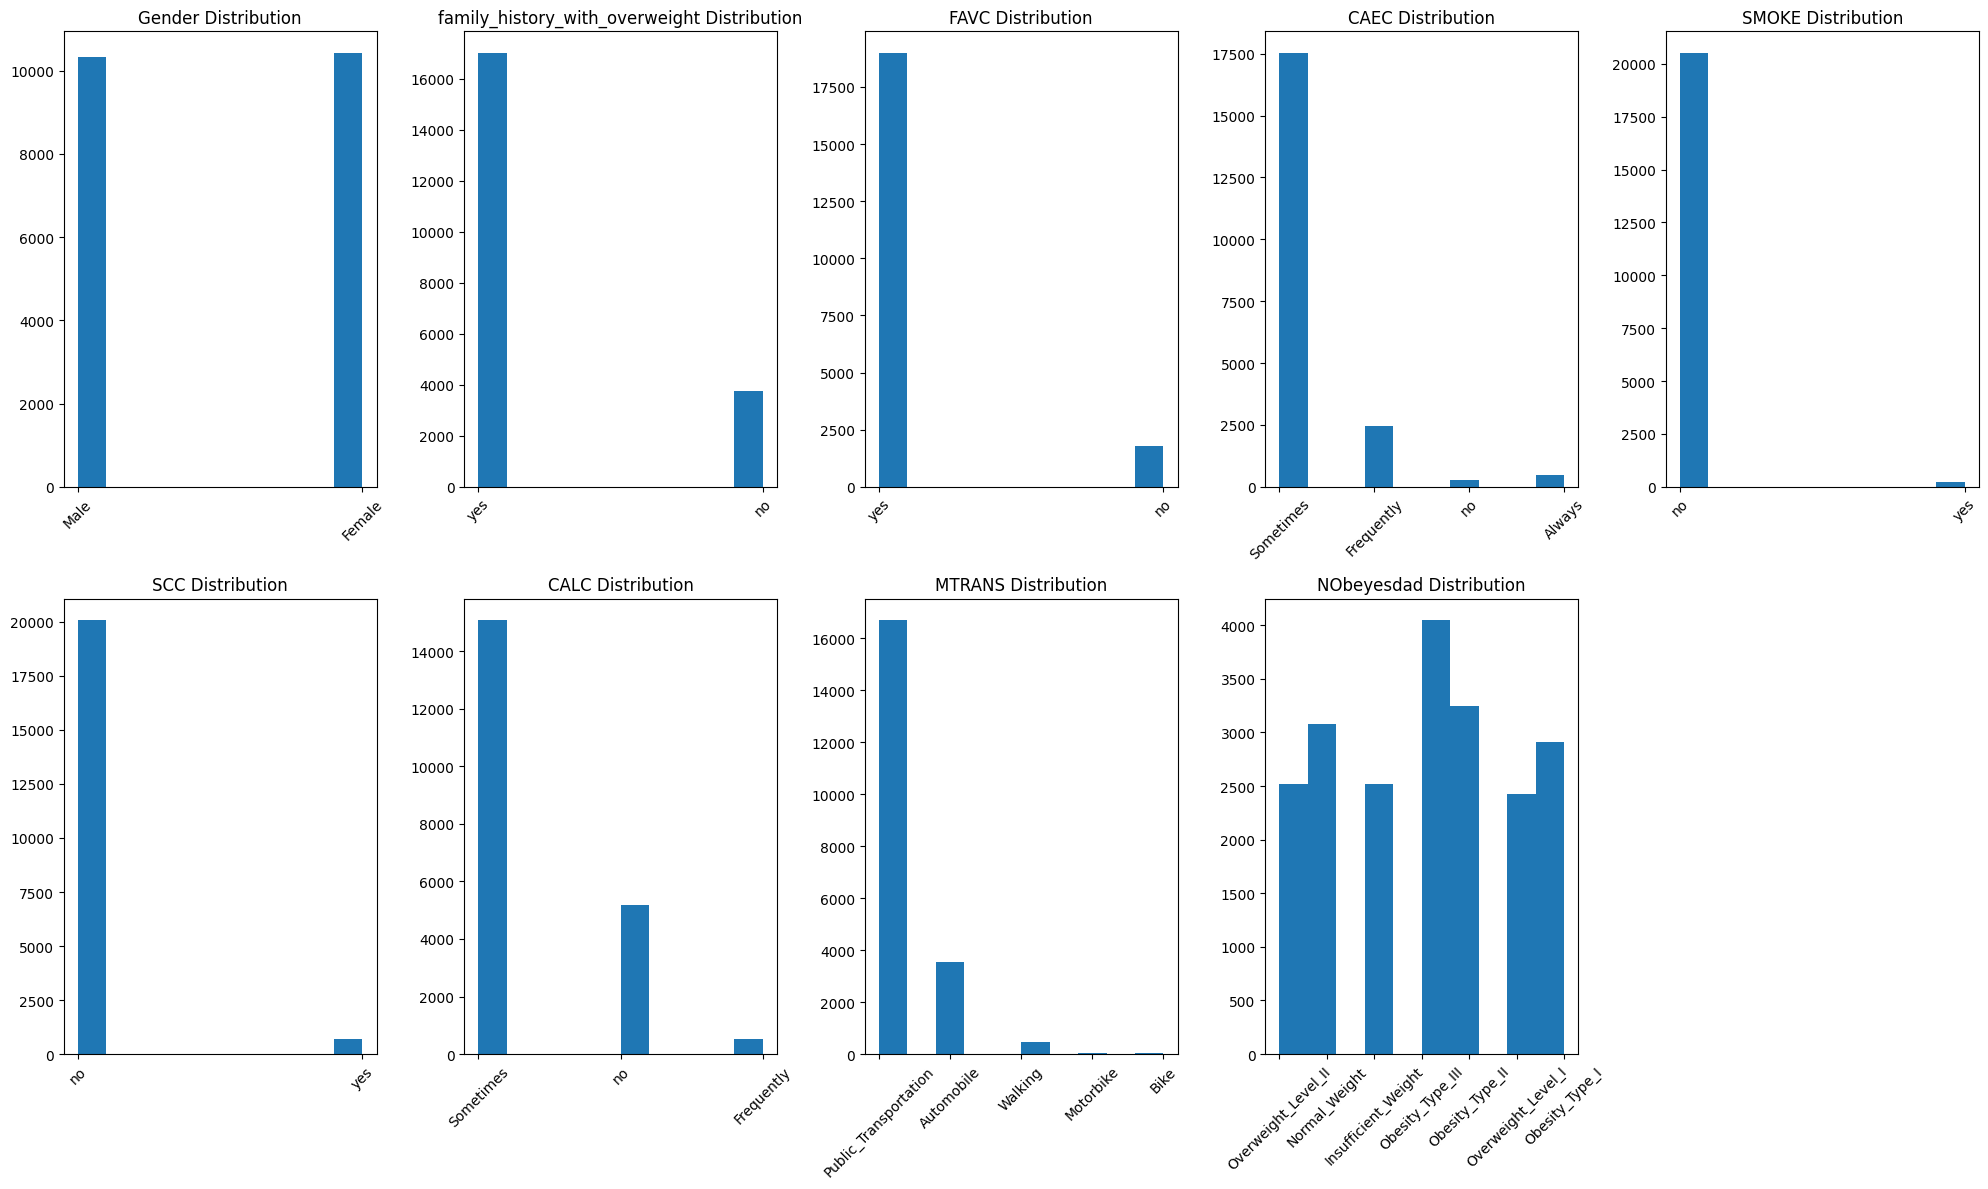

In [10]:
# categorical cols histogram
plt.figure(figsize=(20,6 * num_categorical_rows))
for i ,col in enumerate(categorical_cols,1):
    plt.subplot(num_categorical_rows, 5, i)
    plt.hist(df_train[col])
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show() 


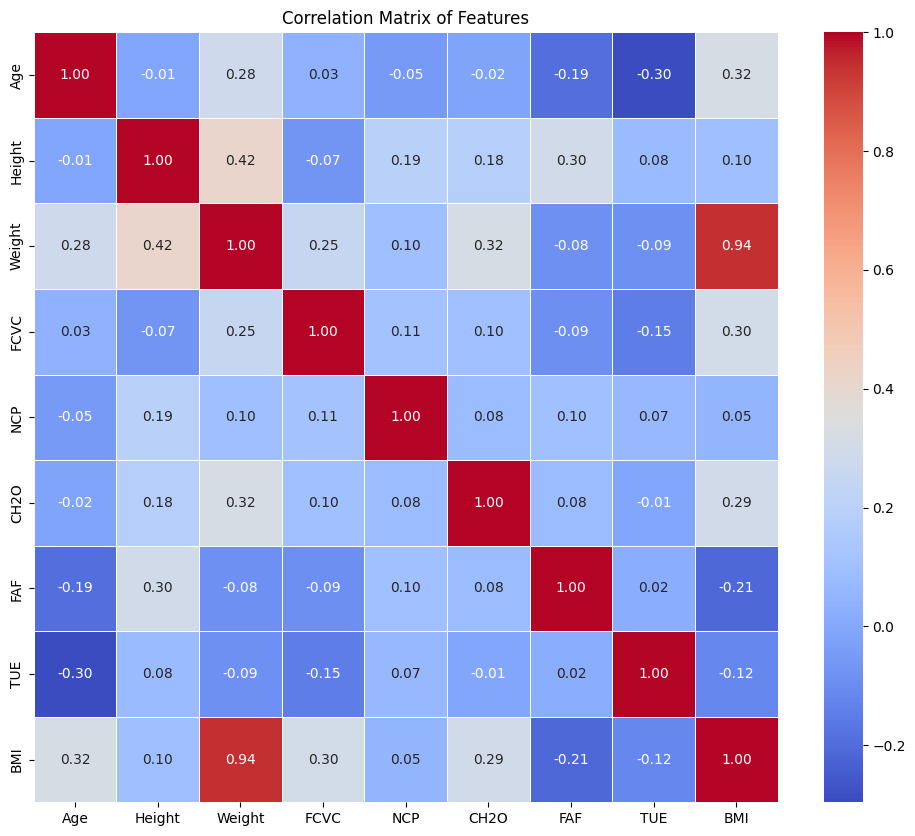

In [11]:
def corr(data):
    plt.figure(figsize=(12,10))
    sns.heatmap(data, annot=True, cmap='coolwarm', fmt='.2f', linewidths= 0.5)
    plt.title('Correlation Matrix of Features')
corr(df_train[numerical_cols].corr())

In [12]:
from sklearn.model_selection import train_test_split

y = df_train['NObeyesdad']
x = df_train.copy().drop(columns=['NObeyesdad'])

categoricals_cols_no_result = categorical_cols.remove("NObeyesdad")
x = pd.get_dummies(x, columns=categoricals_cols_no_result, drop_first=True)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.20)

## Decision Tree

In [13]:
from sklearn.tree import DecisionTreeClassifier

# clf = DecisionTreeClassifier(ccp_alpha=0.01) - avoid overfitting
clf = DecisionTreeClassifier()
clf = clf.fit(x_train,y_train)

In [14]:
# do actual predictions
predictions = clf.predict(x_test)
predictions

array(['Normal_Weight', 'Insufficient_Weight', 'Overweight_Level_II', ...,
       'Obesity_Type_III', 'Obesity_Type_I', 'Insufficient_Weight'],
      shape=(4152,), dtype=object)

In [15]:
# check accuracy
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test,predictions))

0.8460982658959537


In [16]:
# check accuracy
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test,predictions,labels=labels))

[[357  10   0   0   8  65  65]
 [ 16 466  52   1   0  59   4]
 [  1  50 441   0   0   3   0]
 [  0   1   1 820   0   0   2]
 [  4   0   0   1 629   0  30]
 [ 70  55   3   2   3 313  23]
 [ 58   1   0   1  32  18 487]]


In [17]:
# check accuracy
from sklearn.metrics import precision_score

print(precision_score(y_test,predictions,average='macro')) # i don't know why macro

0.8289404080302595


In [18]:
from sklearn.metrics import recall_score

recall_score(y_test, predictions,average='macro') # i don't know why macro

0.8289516540107443

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, target_names=labels))



                     precision    recall  f1-score   support

Overweight_Level_II       0.89      0.89      0.89       495
      Normal_Weight       0.80      0.78      0.79       598
Insufficient_Weight       0.80      0.82      0.81       597
   Obesity_Type_III       0.94      0.95      0.94       664
    Obesity_Type_II       0.99      1.00      0.99       824
 Overweight_Level_I       0.68      0.67      0.68       469
     Obesity_Type_I       0.71      0.71      0.71       505

           accuracy                           0.85      4152
          macro avg       0.83      0.83      0.83      4152
       weighted avg       0.85      0.85      0.85      4152



In [20]:
feature_importance = pd.DataFrame(clf.feature_importances_, index = x.columns).sort_values(0, ascending=False)
feature_importance

,0
BMI,0.582135
Weight,0.170885
Gender_Male,0.049199
Age,0.042172
Height,0.021629
CH2O,0.021143
FCVC,0.018703
FAF,0.017275
TUE,0.016791
NCP,0.014301


<Axes: >

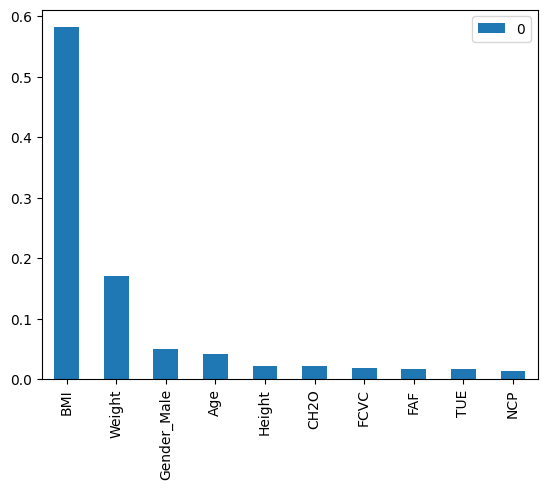

In [21]:
feature_importance.head(10).plot(kind='bar')

In [22]:
# builds the decision tree and takes too long to compute
""" from sklearn import tree
from matplotlib import pyplot as plt

class_names = {}
for i in range(0,len(labels)):
  class_names[i] = labels[i]

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=x.columns,  
                   class_names=class_names,
                   filled=True,
                  fontsize=12) """

' from sklearn import tree\nfrom matplotlib import pyplot as plt\n\nclass_names = {}\nfor i in range(0,len(labels)):\n  class_names[i] = labels[i]\n\nfig = plt.figure(figsize=(25,20))\n_ = tree.plot_tree(clf, \n                   feature_names=x.columns,  \n                   class_names=class_names,\n                   filled=True,\n                  fontsize=12) '

In [23]:
from sklearn.model_selection import train_test_split

y = df_train['NObeyesdad']
x = df_train.copy().drop(columns=['NObeyesdad'])

if("NObeyesdad" in categorical_cols): 
  categoricals_cols_no_result = categorical_cols.remove("NObeyesdad")
x = pd.get_dummies(x, columns=categoricals_cols_no_result, drop_first=True)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.20)

##  Support Vector Machines

In [24]:
from sklearn.svm import SVC

model = SVC()
model.fit(x_train,y_train)
model.score(x_test,y_test)

0.8270712909441233

In [25]:
modelC = SVC(C=1000)
modelC.fit(x_train,y_train)
modelC.score(x_test,y_test)

0.8853564547206165

In [26]:
modelGamma = SVC(gamma=10)
modelGamma.fit(x_train,y_train)
modelGamma.score(x_test,y_test)

0.3258670520231214

In [28]:
modelLinearKernel = SVC(kernel='linear',C=1000)
modelLinearKernel.fit(x_train,y_train)
modelLinearKernel.score(x_test,y_test)

0.869942196531792